In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
import re
import numpy as np
import pandas as pd
from graphdot import Graph
from graphdot.kernel.marginalized import MarginalizedGraphKernel
from graphdot.kernel.basekernel import TensorProduct
from graphdot.kernel.basekernel import SquareExponential
from graphdot.kernel.basekernel import KroneckerDelta
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [18]:
import networkx as nx
from rdkit.Chem import MolFromSmiles
def smile2graph(smile):
    mol = MolFromSmiles(smile)

    if mol is not None:
        g = nx.Graph()

        for i, atom in enumerate(mol.GetAtoms()):
            g.add_node(i)
            #g.nodes[i]['symbol'] = atom.GetAtomicNum()
            g.nodes[i]['charge'] = atom.GetFormalCharge()
            g.nodes[i]['hcount'] = atom.GetTotalNumHs()
            g.nodes[i]['hybridization'] = atom.GetHybridization()
            g.nodes[i]['aromatic'] = atom.GetIsAromatic()
            g.nodes[i]['chiral'] = atom.GetChiralTag()

        for bond in mol.GetBonds():
            ij = (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
            g.add_edge(*ij)
            g.edges[ij]['order'] = bond.GetBondType()
            g.edges[ij]['aromatic'] = bond.GetIsAromatic()
            g.edges[ij]['conjugated'] = bond.GetIsConjugated()
            g.edges[ij]['stereo'] = bond.GetStereo()
            g.edges[ij]['inring'] = bond.IsInRing()

        return Graph.from_networkx(g)
    else:
        return None
    
# defining kernel
class NormalizedKernel(MarginalizedGraphKernel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def __normalize(self, X, Y, R):
        if type(R) is tuple:
            d = np.diag(R[0])**-0.5
            K = np.diag(d).dot(R[0]).dot(np.diag(d))
            return (K, R[1])
        else:
            if Y is None:
                # square matrix
                d = np.diag(R)**-0.5
                K = np.diag(d).dot(R).dot(np.diag(d))
            else:
                # rectangular matrix, must have X and Y
                diag_X = super().diag(X)**-0.5
                diag_Y = super().diag(Y)**-0.5
                K = np.diag(diag_X).dot(R).dot(np.diag(diag_Y))
            return K
    def __call__(self, X, Y=None, *args, **kwargs):
        R = super().__call__(X, Y, *args, **kwargs)
        return self.__normalize(X, Y, R)

#initializing kernel
knode = TensorProduct(aromatic=KroneckerDelta(0.8),
                      charge=SquareExponential(1.0),
                      hcount=SquareExponential(1.0))

kedge = TensorProduct(order=KroneckerDelta(0.5))

normal_kernel = NormalizedKernel(knode, kedge, q=0.05)
kernel = MarginalizedGraphKernel(knode, kedge, q=0.05)

RDKit WARNING: [06:57:40] Enabling RDKit 2019.09.3 jupyter extensions


In [68]:
class OutputHandler():
    def __init__(self, filename, relative_dir='../result'):
        self.df = pd.read_csv(os.path.join(relative_dir, filename), sep=" ")
        self._parse_argument(filename)
    def _parse_argument(self, filename):
        self.target, self.learning_mode, self.add_mode, self.add_size, _ = re.split('-', filename)

In [69]:
pathDir = os.listdir('../result')

In [70]:
sorted(pathDir)

['dc-random-cluster-10-comp.out',
 'dc-supervised-cluster-10-comp.out',
 'dc-supervised-nlargest-10-comp.out',
 'dc-supervised-random-10-comp.out',
 'dc-unsupervised-cluster-10-666.out',
 'dc-unsupervised-cluster-10-comp.out',
 'dc-unsupervised-cluster-10-debug.out',
 'dc-unsupervised-nlargest-10-comp.out',
 'dc-unsupervised-random-10-comp.out',
 'dc-unsupervised-threshold-10-threshold_test_11.out',
 'dc-unsupervised-threshold-10-threshold_test_9.out',
 'dc-unsupervised-threshold-200-10-threshold_test.out']

# comparison between different add mode for unsupervised active learning on dc

In [29]:
def plot_oh(oh, get_str, target='r2'): # oh==OutputHandler
    if oh.learning_mode == 'supervised':
        color = 'cornflowerblue'
    elif oh.learning_mode == 'random':
        color = 'grey'
    elif oh.learning_mode == 'unsupervised':
        color = 'orange'
    if oh.add_mode == 'cluster':
        linestyle = '-'
    elif oh.add_mode == 'nlargest':
        linestyle = '--'
    elif oh.add_mode == 'random':
        linestyle = '-.'
    #plt.scatter(oh.df['size'], oh.df[target], s=5, c=color)
    plt.plot(oh.df['size'], oh.df[target], c=color, linestyle=linestyle, label=get_str(oh))
    
def get_str(oh):
    return ('%s-%s' % (oh.learning_mode, oh.add_mode) )

In [31]:
out_list = ['dc-random-cluster-10-comp.out',
 #'dc-supervised-cluster-10-comp.out',
 'dc-supervised-nlargest-10-comp.out',
 #'dc-supervised-random-10-comp.out',
 'dc-unsupervised-cluster-10-comp.out',
 'dc-unsupervised-nlargest-10-comp.out',
 'dc-unsupervised-random-10-comp.out']

oh_list = [OutputHandler(i) for i in out_list]
df_threshold_9 = pd.read_csv('../result/dc-unsupervised-threshold-10-threshold_test_9.out', sep=" ")
df_threshold_11 = pd.read_csv('../result/dc-unsupervised-threshold-10-threshold_test_11.out', sep=" ")
df_threshold_9.drop( df_threshold_9 [df_threshold_9['r2']<0.75].index, inplace=True )
df_threshold_11.drop( df_threshold_11 [df_threshold_11['r2']<0.75].index, inplace=True )

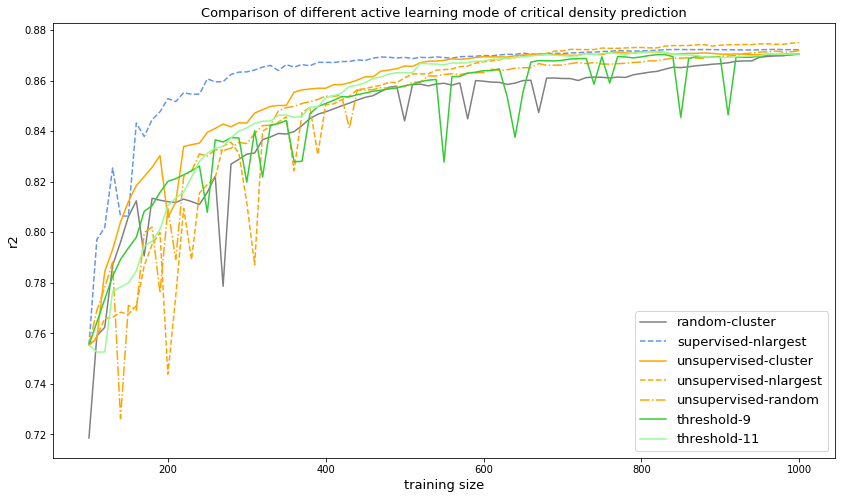

In [32]:
fig = plt.figure(figsize=(14,8))
for oh in oh_list:
    plot_oh(oh, get_str, 'r2')
fontsize = 13
#plt.plot(df_old_cluster['size'], df_old_cluster['r2'], c='r', label='old-unsupervised-cluster')
plt.plot(df_threshold_9['size'], df_threshold_9['r2'], c='limegreen', label='threshold-9')
plt.plot(df_threshold_11['size'], df_threshold_11['r2'], c='palegreen', label='threshold-11')

plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('r2', fontsize=fontsize)
plt.title('Comparison of different active learning mode of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

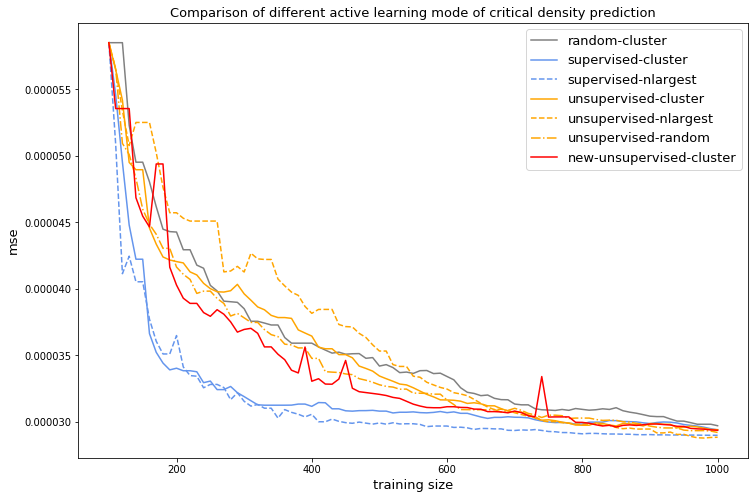

In [11]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list:
    plot_oh(oh,  get_str, 'mse')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.plot(df_new_cluster['size'], df_new_cluster['mse'], c='r', label='new-unsupervised-cluster')
plt.ylabel('mse', fontsize=fontsize)
plt.title('Comparison of different active learning mode of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

# comparison for different search size for unsupervised

In [34]:
out_list2 =  [ 'dc-unsupervised-random-200-5.out',
 'dc-unsupervised-random-400-5.out',
 'dc-unsupervised-random-50-5.out',
 'dc-unsupervised-random-0-5.out',
 'dc-unsupervised-cluster-0-5.out',
 'dc-unsupervised-cluster-200-5.out',
 'dc-unsupervised-cluster-400-5.out',
 'dc-unsupervised-cluster-50-5.out'
            ]

In [35]:
oh_list2 = [OutputHandler(i) for i in out_list2]

In [36]:
def plot_oh2(oh, get_str, target='r2'): # oh==OutputHandler
    if oh.add_mode == 'random':
        linestyle = '-'
    elif oh.add_mode == 'cluster':
        linestyle = '--'

    if oh.search_size == '0':
        color = 0
    else:
        color = (1-int(oh.search_size)**0.5 / 25)
    cmap=plt.get_cmap('autumn')
    plt.plot(oh.df['size'], oh.df[target], c=cmap(color), label=get_str(oh), linestyle=linestyle)
    
def get_str(oh):
    return ('%s-%s' % (oh.learning_mode, oh.add_mode) )

def get_str2(oh):
    return ('%s-search:%s-add:%s' % (oh.add_mode, oh.search_size, oh.add_size))

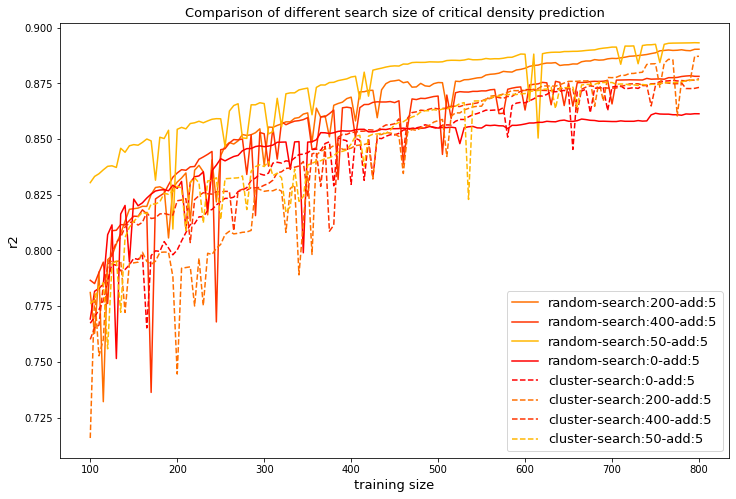

In [37]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list2:
    plot_oh2(oh, get_str2, 'r2')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('r2', fontsize=fontsize)
plt.title('Comparison of different search size of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

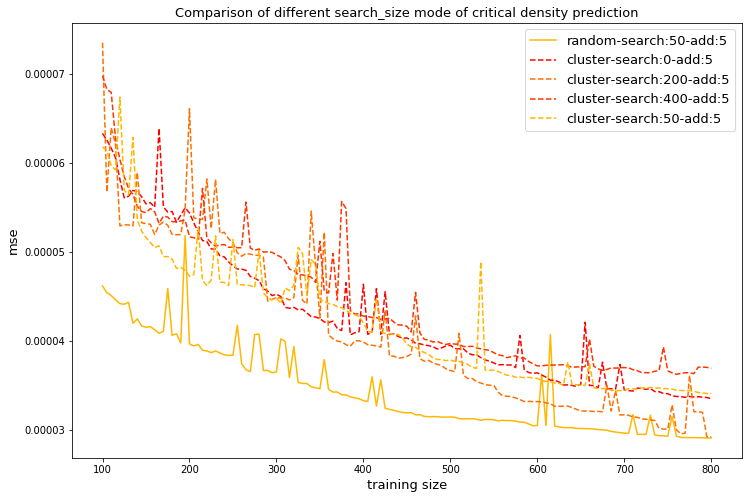

In [13]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list2:
    plot_oh2(oh, get_str2, 'mse')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('mse', fontsize=fontsize)
plt.title('Comparison of different search_size mode of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

# comparison for different add size for unsupervised

In [17]:
out_list3 =  [ 
 'dc-unsupervised-cluster-200-10.out',
 'dc-unsupervised-cluster-200-40.out',
 'dc-unsupervised-cluster-200-5.out',
 'dc-unsupervised-random-200-10.out',
 'dc-unsupervised-random-200-2.out',
 'dc-unsupervised-random-200-40.out',
 'dc-unsupervised-random-200-5.out',
            ]
oh_list3 = [OutputHandler(i) for i in out_list3]

In [24]:
def plot_oh3(oh, get_str, target='r2'): # oh==OutputHandler
    if oh.add_mode == 'random':
        linestyle = '-'
    elif oh.add_mode == 'cluster':
        linestyle = '--'

    if oh.search_size == '0':
        color = 1
    else:
        color = int(oh.add_size)**0.5 / 5
    color = 1-color
    cmap=plt.get_cmap('autumn')
    plt.plot(oh.df['size'], oh.df[target], c=cmap(color), label=get_str(oh), linestyle=linestyle)
    
def get_str(oh):
    return ('%s-%s' % (oh.learning_mode, oh.add_mode) )

def get_str3(oh):
    return ('%s-search:%s-add:%s' % (oh.add_mode, oh.search_size, oh.add_size))

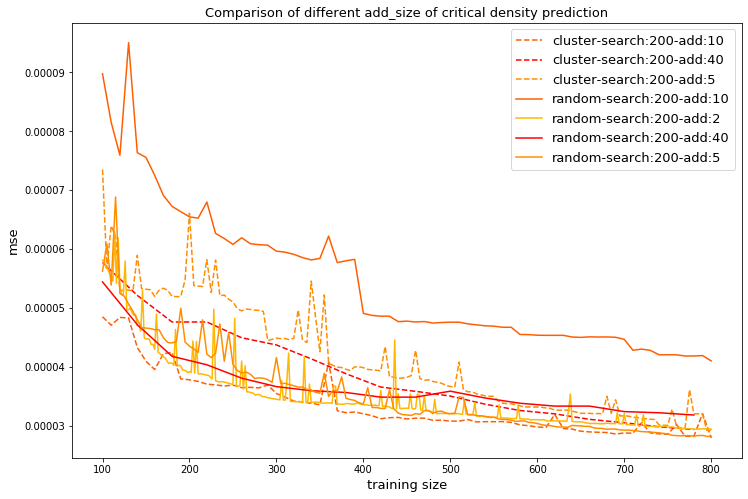

In [25]:
fig = plt.figure(figsize=(12,8))
for oh in oh_list3:
    plot_oh3(oh, get_str3, 'mse')
fontsize = 13
plt.xlabel('training size', fontsize=fontsize)
plt.ylabel('mse', fontsize=fontsize)
plt.title('Comparison of different add_size of critical density prediction', fontsize=fontsize)
plt.legend(fontsize=fontsize)

# std change 

In [3]:
pathDir2 = os.listdir('../log/std_log')

pathDir2

['99-970.csv',
 '859-210.csv',
 '429-640.csv',
 '669-400.csv',
 '189-880.csv',
 '739-330.csv',
 '579-490.csv',
 '489-580.csv',
 '809-260.csv',
 '719-350.csv',
 '249-820.csv',
 '969-100.csv',
 '539-530.csv',
 '139-930.csv',
 '709-360.csv',
 '749-320.csv',
 '179-890.csv',
 '449-620.csv',
 '759-310.csv',
 '919-150.csv',
 '929-140.csv',
 '439-630.csv',
 '599-470.csv',
 '549-520.csv',
 '839-230.csv',
 '209-860.csv',
 '319-750.csv',
 '789-280.csv',
 '629-440.csv',
 '459-610.csv',
 '169-900.csv',
 '829-240.csv',
 '879-190.csv',
 '409-660.csv',
 '279-790.csv',
 '569-500.csv',
 '649-420.csv',
 '769-300.csv',
 '149-920.csv',
 '299-770.csv',
 '729-340.csv',
 '479-590.csv',
 '129-940.csv',
 '799-270.csv',
 '949-120.csv',
 '159-910.csv',
 '679-390.csv',
 '559-510.csv',
 '119-950.csv',
 '349-720.csv',
 '219-850.csv',
 '199-870.csv',
 '289-780.csv',
 '419-650.csv',
 '959-110.csv',
 '269-800.csv',
 '899-170.csv',
 '689-380.csv',
 '869-200.csv',
 '229-840.csv',
 '79-990.csv',
 '519-550.csv',
 '89-980.c

In [4]:
df_list = []
for file in pathDir2:
    df = pd.read_csv('../log/std_log/'+file)
    df['size'] = re.split('-|\.', file)[1]
    df_list.append(df)

df = pd.concat(df_list)

grouped = df.groupby('size')

describe = grouped['std'].describe()
describe

,count,mean,std,min,25%,50%,75%,max
size,,,,,,,,
100,969.0,17.621342,5.808824,7.192996,13.653022,16.176315,20.368622,49.493397
1000,69.0,25.789394,6.877937,13.692517,19.077188,26.974915,30.694099,39.283302
110,959.0,15.575455,3.860560,6.188198,12.926642,14.890223,17.934598,29.144459
120,949.0,15.287023,3.669099,6.078351,12.818536,14.737287,17.407360,28.039122
130,939.0,15.162978,3.588978,6.058292,12.737290,14.599175,17.244261,27.590105
...,...,...,...,...,...,...,...,...
950,119.0,33.630902,13.182152,12.444082,20.409752,34.926342,44.447083,62.098629
960,109.0,22.830756,6.055011,11.030764,17.508348,21.752272,28.042456,38.760284
970,99.0,23.285011,6.130357,11.033134,18.366412,23.000513,28.301848,39.004410


283

In [5]:
for i in range(20,40):
    print(len(grouped.get_group(str(10*i))[grouped.get_group(str(10*i))['std'] > 13]))

491
479
598
647
644
574
576
572
579
663
632
612
594
562
557
556
551
541
514
522


In [7]:
result_log = pd.read_csv('../result/dc-unsupervised-threshold-10-std_log.out', sep=' ')

r2_out = [result_log[result_log['size']==i*100]['r2'].values for i in range(1,10)]

No handles with labels found to put in legend.


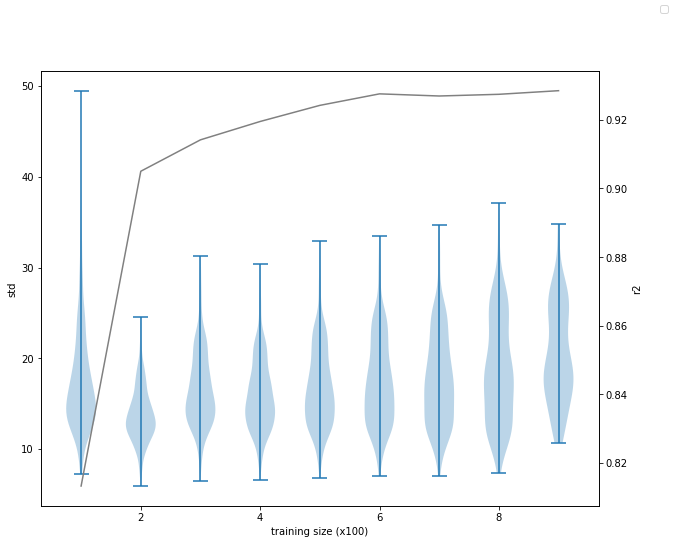

In [8]:
fig, ax1 = plt.subplots(figsize=(10,8))

ax1.violinplot([grouped.get_group(str(i*100))['std'] for i in range(1,10)])
ax1.set_xlabel('training size (x100)')
ax1.set_ylabel('std')

ax2 = ax1.twinx()
ax2.plot([i for i in range(1,10)], r2_out, c='gray')
ax2.set_ylabel('r2')
fig.legend()

In [16]:
grouped.get_group(str(300))['SMILES']

0       C/C=C(/C(C)(C)C)\C
1          C/C=C(/C(C)C)\C
2            C/C=C(/C=C)\C
3      C/C=C(/CCC=C(C)C)\C
4          C/C=C(\C(C)C)/C
              ...         
764      Cc1cccc(c1)C(=C)C
765    Cc1cccc(c1)C(C)(C)C
766       Cc1cccc(c1)C(C)C
767             Cc1ccccc1C
768         Cc1ccccc1C1CC1
Name: SMILES, Length: 769, dtype: object

In [19]:
kernel_list = [smile2graph(i) for i in grouped.get_group(str(300))['SMILES'].values]

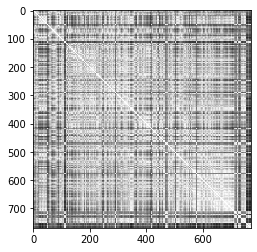

In [20]:
a_kernel = normal_kernel(kernel_list)
plt.imshow(a_kernel, cmap=plt.cm.gray)

(array([3.6000e+01, 7.3000e+01, 3.2700e+02, 9.4000e+02, 2.0680e+03,
        3.7630e+03, 6.1310e+03, 8.5490e+03, 1.1453e+04, 1.4333e+04,
        1.6595e+04, 1.7631e+04, 1.9540e+04, 2.2230e+04, 2.6981e+04,
        3.3246e+04, 3.8654e+04, 3.8589e+04, 2.7242e+04, 6.9150e+03]),
 array([0.12003319, 0.16403154, 0.20802988, 0.25202823, 0.2960266 ,
        0.34002492, 0.38402328, 0.4280216 , 0.47201997, 0.51601833,
        0.56001663, 0.604015  , 0.64801335, 0.6920117 , 0.73601   ,
        0.7800084 , 0.82400674, 0.8680051 , 0.9120034 , 0.95600176,
        1.0000001 ], dtype=float32),
 <a list of 20 Patch objects>)

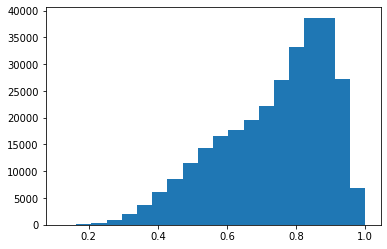

In [21]:
plt.hist(a_kernel[np.triu_indices(769, k = 1)], bins=20)

In [23]:
a_kernel

array([[1.        , 0.85063505, 0.77761316, ..., 0.5265604 , 0.4043081 ,
        0.39863202],
       [0.85063505, 1.0000001 , 0.8693567 , ..., 0.624412  , 0.41390145,
        0.48210093],
       [0.7776132 , 0.8693567 , 1.0000001 , ..., 0.63621545, 0.4934143 ,
        0.593604  ],
       ...,
       [0.5265604 , 0.624412  , 0.63621545, ..., 0.99999994, 0.92112744,
        0.91134816],
       [0.40430808, 0.41390142, 0.49341428, ..., 0.9211275 , 1.0000001 ,
        0.9251843 ],
       [0.39863205, 0.48210093, 0.593604  , ..., 0.9113482 , 0.9251843 ,
        0.99999994]], dtype=float32)

In [24]:
a_kernel[np.triu_indices(769, k = 1)]

array([0.85063505, 0.77761316, 0.77761316, ..., 0.92112744, 0.91134816,
       0.9251843 ], dtype=float32)

# Nystrom result

In [13]:
df_nystrom = pd.read_csv('../result/dc-unsupervised-cluster-15-nystrom.out', sep=" ")

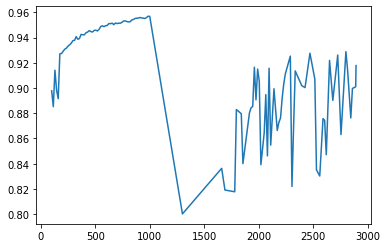

In [15]:
idx = df_nystrom['r2'] > 0.8
plt.plot(df_nystrom['size'][idx], df_nystrom['r2'][idx])